In [3]:
%reload_ext autoreload
%autoreload 2

from pncbf.train import (
    collect_ncbf,
    collect_qp,
    test_ncbf,
    test_qp,
    train_ncbf,
    train_qp,
)
from pncbf.config import Arguments
from pncbf.filter import NullFilter, HandmadeFilter
from pncbf.utils import calculate_gradient

import numpy as np
import random
import torch

args = Arguments()
args.random_seed = 42
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(args.random_seed)
np.random.seed(args.random_seed)
torch.manual_seed(args.random_seed)
np.set_printoptions(precision=2, suppress=True)

In [4]:
args.max_agent_vel = 2
args.world_dims = [0, 100]
args.rollouts = 100
args.steps_per_rollout = 50
args.filter = NullFilter # nominal filter
args.render = False
    
rollout_data = collect_ncbf(args)

In [5]:
args.num_epochs = 100
args.learning_rate = 1e-4
args.hidden_dims = [256, 128, 64, 32]

ncbf_model = train_ncbf(args, rollout_data)

[100/100] | Loss: 0.0116: 100%|██████████| 100/100 [00:00<00:00, 150.60it/s]


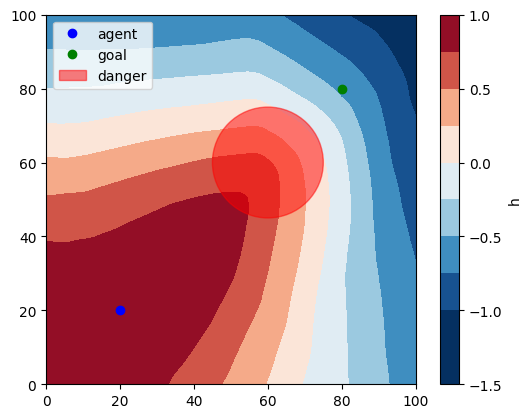

In [6]:
args.contour_grid_size = 100
args.contour_levels = 8

test_ncbf(args, ncbf_model)

In [7]:
args.rollouts = 200
args.steps_per_rollout = 50
args.filter = HandmadeFilter
args.render = False

qp_data = collect_qp(args, ncbf_model)

In [8]:
args.num_epochs = 2000
args.learning_rate = 1e-4
args.hidden_dims = [256, 128, 64, 32]

qp_model = train_qp(args, qp_data)

[7/2000] | Loss: 0.5026:   0%|          | 0/2000 [00:00<?, ?it/s]

[2000/2000] | Loss: 0.0031: 100%|██████████| 2000/2000 [00:07<00:00, 279.55it/s]


In [9]:
# args.rollouts = 5
# args.steps_per_rollout = 75

# _ = test_qp(args, qp_model)

In [18]:
from pncbf.state import State
from pncbf.env import Environment

print(calculate_gradient(ncbf_model, State().to_tensor(args.device)))
print(calculate_gradient(qp_model, State().to_tensor(args.device)))

tensor([-0.0011, -0.0060,  0.0091, -0.0031, -0.0001, -0.0006, -0.0050,  0.0036,
         0.0113,  0.0070, -0.0026,  0.0044], device='cuda:0')
tensor([-0.0550,  0.0172,  0.0567, -0.0165,  0.0241,  0.0194, -0.0372,  0.0359,
         0.0226, -0.0196, -0.0549,  0.0325], device='cuda:0')


In [ ]:
s = State()
s.goal_vel = np.array([1, 1])
s.danger_vel = np.array([50, 50])

f, g = Environment(args, None).get_affine_dynamics(s)
print(f)
print(g)

In [ ]:
from pncbf.qp_solver import solve

grad = calculate_gradient(ncbf_model, State().to_tensor(args.device))
u_nominal = np.array([1, 1])

solve(grad, f, g, -100, u_nominal)